<a href="https://colab.research.google.com/github/cergin07/MultiLayer-Perceptron-Regression-on-Car-Prices/blob/main/Multilayer_Perceptron_Regression_on_Car_Prices_Prediction_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilayer Perceptron Regression on Car Prices Prediction Problem

In this notebook,I will explain how can we use a multi layer perceptron to predic car prices.
In this problem I will use Sklearn MLPRegressor 

I will use "carpricestrain.csv" file for train and test a model

> Specifically for this problem , we are going to do the following:
> - Load the dataset
> - Preprocess the data
> - Build the model
> - Train the model
> - Predict data

**Before we build the models,we should talk about what multilayer perceptron is.**

MLP is consists of at least three layers of nodes: an input layer, a hidden layer and an output layer.

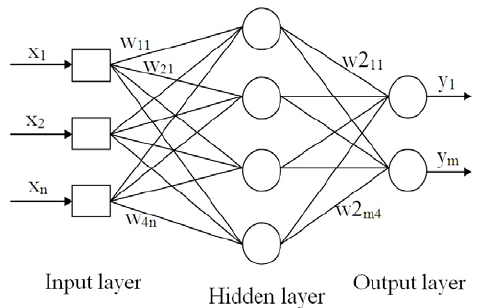



One neuron may not be enough for many inputs. The layer concept comes into play when more than one neuron performing parrallel processing is needed. As you can see, unlike the single perceptron model, there is atlest one hidden layer. The input layer receives the incomnig data and sends it to the middleware. Incoming information is transferred to the next layer. The number of intermediate layers varies according to the problem, at least one, and is adjusted according to the needs. 

**Input Layer:** It is the layer where the attributes of the sample that is wanted to be learned as input to a network are given as input. There should be as many input neurons as the number of attributes of the samples to be taught in the input layer.

**Output Layer:** It is the layer where the class information or label value or predicted real value of the samples in the artificial network is calculated as output.

**Hidden Layers:** These are the layers between the input layer and the output layers. The number of layers and the number of neurons on them can vary from problem to problem. Forward calculations and backward error propagation are performed in these layers.

Any mathematical function can be used as an activation function in the model. However, sigmoid, tang, linear, threshold and hard limiter functions are the most used functions. But in Scikit-learn library there is no activation function in the output layer.For regression scenarios, the square error is the loss function.

 **What is Forward Propagation**

In the multilayer perceptron models, the journey starting from the input to the output is called the forward. The weights entering each node are multiplied by the value and bias is added.
This process continues throughout the hidden layers until the outputlayer.
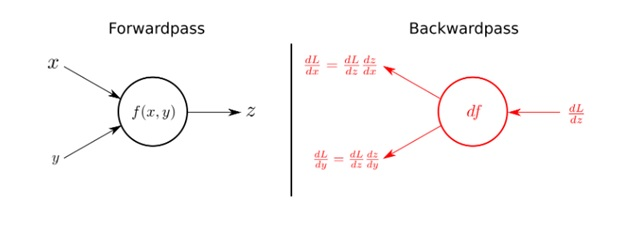

For example:
Z1 = W1* A0 +B1
A1=f(Z1)
=>
Z2=W2*A1+B2
A2=f(Z2)
...

and the process goes until reach the output layer with using activation function. and calculates loss.
As Activation function I use logistic. **"Logistic" is the sigmoid function which returns 1/(1+exp(-x))**

In multilayer perceptron each layer is feeding the next one with the result of their computation, their internal representation of the data. This goes all the way through the hidden layers to the output layer. But there is a problem. If the algorithm only computed one iteration, there would be no actual learning. Therefore,in this scenario a concept called backpropagation welcomes us.



**What is Backpropagation**

Backpropagation is the learning mechanism that allows the MLP to iteratively adjust the weights for minimizing the cost function.
For this purpose, the Gradient Descent optimization algorithm is used. This algorithm uses the first derivative to converge to the local minimum of the equation.

In each iteration, after the wighted sums are forwarded through all layers, the gradient of the Mean Squared Error is computed across all input and output pairs.Then, to propagate it back, the weights of the first hidden layer are updated with the value of the gradient.That's how the weights are propagated back to the starting point of the neural network.

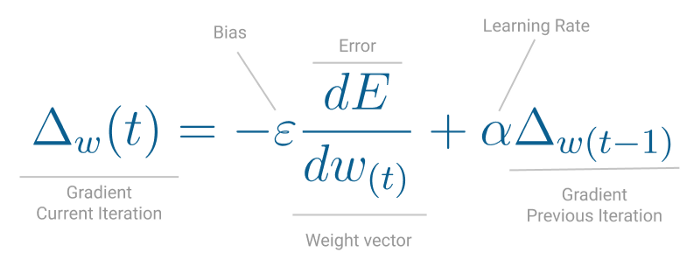


This process continues until the calculated gradient no longer changes or changes very little.



In [ ]:
%cd /content/drive/MyDrive/CSE463/perceptron/

/content/drive/MyDrive/CSE463/perceptron


In [ ]:
import pandas as pd
import numpy as np
import abc
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Now we create a class named "Trainer". Trainer class is base class for MLP regressor model,In this method we will define methods which will define as abstractmethod for override them in Car classes.

> ReadCsvFilesAndModify method is responsible for reading the csv file and preparing the data.

> GetTrainSet method returns modified data set.

> CalculateMetrics method is responsible for calculate ME, RMSE, MAE, MAPE metrics.


> Train method is main method to build a model, train it and test it, calculates metricts.

*Now lets create Trainer class. *

In [ ]:
class Trainer:
  
  @abc.abstractmethod
  def ReadCsvFilesAndModify(self,fileName,learningRate=0.001):
    pass

  @abc.abstractmethod
  def GetTrainSet(self):
    pass

  @abc.abstractmethod
  def CalculateMetrics(self,resultDf,metricsArray,testSetLength):
    pass
  @abc.abstractmethod
  def Train(self,X_train,y_train,X_test):
    pass

In [ ]:
class Car(Trainer):
  def __init__(self,fileName,learningRate=0.01):
    self.trainSet = {}
    self.fileName=fileName
    self.learningRate=learningRate
    self.trainSet=self.ReadCsvFilesAndModify(fileName)

  def ReadCsvFilesAndModify(self,fileName):
      trainSet = pd.read_csv(fileName);
      trainSet = pd.get_dummies(trainSet,columns=['fuelType','transmission'],drop_first=True)
      features=trainSet.drop(['model','price'],axis=1)
      labels=trainSet['price']

      X_train,X_test,y_train,y_test=train_test_split(features,labels,test_size=0.3,random_state=1)

      self.metricsArray= pd.DataFrame(index=['ME','RMSE','MAE','MAPE'],columns = ['MLP'])
      self.resultDataFrameArray=pd.DataFrame(index=X_test.index,columns=['Real'])
      self.resultDataFrameArray.Real=y_test
      datas = {"X_train":X_train,"X_test":X_test,"y_train":y_train,"y_test":y_test};
      return datas;

  def GetTrainSet(self):
      return self.trainSet

  def CalculateMetrics(self,resultDf,metricsArray,testSetLength):
    metricsArray.at['ME','MLP'] = np.sum((resultDf.Real - resultDf['MLP']))/testSetLength
    metricsArray.at['RMSE','MLP'] = np.sqrt(np.sum(resultDf.apply(lambda sample:(sample.Real-sample['MLP'])**2,axis=1)))/testSetLength
    metricsArray.at['MAE','MLP'] = np.sum(abs(resultDf.Real-resultDf['MLP']))/testSetLength
    metricsArray.at['MAPE','MLP'] = np.sum(resultDf.apply(lambda sample:abs(sample.Real-sample['MLP'])/sample.Real,axis=1))/testSetLength*100
    return metricsArray

  def Train(self,X_train,y_train,X_test):  
    carMlpModel=MLPRegressor(hidden_layer_sizes=5,max_iter=2000,activation="logistic")
    carMlpModel.fit(X_train,y_train)
    self.resultDataFrameArray['MLP']=carMlpModel.predict(X_test)
    self.resultDataFrameArray['MLPREAL'] = abs(self.resultDataFrameArray.MLP-self.resultDataFrameArray.Real)
    lenTestSet=len(self.resultDataFrameArray)
    self.metricsArray =self.CalculateMetrics(self.resultDataFrameArray,self.metricsArray,lenTestSet)
    print(self.metricsArray)

**Now Let's use our prepared class and methods on the iris.csv file and examine the results**

In [ ]:
car = Car("carpricestrain.csv")
datas=car.GetTrainSet()
car.Train(datas["X_train"],datas["y_train"],datas["X_test"])


          MLP
ME    22724.3
RMSE  537.929
MAE   22724.3
MAPE  98.2327


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


**ME(Mean Error)** 

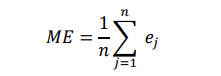

The mean error is the average error between the predicted values  predicted by a machine learning model and the actual values.Error in this context is the uncertainty in a measurement or the diffrence between the estimated value and the actual value.

**RMSE(Roote Mean Square Error)**

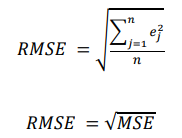

Its is a quadratic metric that measures the magnitude of error of a machine larning model, which is often used to find the distance between the predicted values of the estimator and the actual values.The RMSE is the standar deviation of the estimation error.A zero RMSE value means that the model made no errors.RMSE has the advantage of penalizing major mistakes more so it may be better suited to some situations.

**MAE(Mean Absolute Error)**

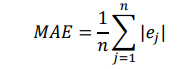

The mean absolute error is a measure of the difference between two continuous variables.MAE is the average vertical distance between each true value and the line that best fits the data.Since the MAE value is easily interpretable,it is frequently used in regression problems.

**MAPE(Mean Absolute Percentage Error)**

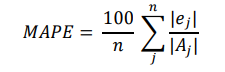

In regression models, the mean absolute percent error is frequently used to measure the accuracy of predictions.

Substract the value Dt representing the demand realized at time(t) and Ft representing the estimated demand for the same time(t) and divide by the actual value.Thus, it is determined how much the predicted value differs from the true value. This error value is included in the calculations as its absolute value, because (-) and (+) values should be prevented from canceling each other out during the addition. When the total value reached is divided by the number of periods in the time series and multiplied by 100, it is determined how much the forecast deviate from the actual values by what percentage of the actual values.
